## CIFAR-10 Dataset Classification using K-Nearest Neighbors (Euclidean)

### Summary
<img align="right" src="../image/NearestNeighbor.png" width=150 height=150>
KNN은 새로운 데이터가 주어졌을 때 기존 데이터 가운데 가장 가까운 k개 이웃의 정보로 새로운 데이터를 예측하는 알고리즘

새로운 데이터가 주어진 경우 기존 모든 데이터와의 거리를 계산한다. 계산된 거리 값이 작은 k개의 데이터를 선정한다. 새로운 데이터의 클래스는 선정된 데이터들의 클래스 중 가장 많이 선택된 클래스로 분류한다.

CIFAR-10 데이터셋을 분류하기 위해 kNN을 사용한다. 그리고 PCA를 이용하여 차원 축소 후 kNN을 이용하여 분류를 진행한다.

<span style="color: #2D3748; background-color:#fff5b1;">Test size를 0.2인 10번 반복 실험한 결과 평균적으로 0.95의 정확도를 보여주고 있고, test 데이터를 분류하는데 0.005초의 시간이 걸린다.</span>

In [2]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils.util import Info
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
class Config(Info):
    def __init__(self):
        super(Info, self).__init__()
        self.device = 'PC'
        self.dataset = 'CIFAR_10'
        self.test_size = 0.2
        self.feature_size = 3072
        self.method = 'kNN'
        self.k = 1
        self.distance = 'Mahalanobis'
        self.reduction_method = [None, None] # method, n_components
        self.iter = 10
    

In [4]:
cig = Config()
cig.info()
cig.print_rutin()

Device ── PC
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Mahalanobis
│
├──Dimension reduction
│    └────Method: None
│    └────Component size: None
│    └────Feature Reduction Ratio: None%
│
└──Iteration
    └────10
PC - CIFAR_10(80%) - kNN - 10 iteration


## Load CIFAR-10 Dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

print(trainset.data.shape)
print(testset.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3)
(10000, 32, 32, 3)


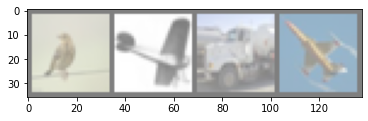

In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [7]:
features = trainset.data.reshape(-1, cig.feature_size)
target = trainset.targets

print(np.array(features).shape)
print(np.array(target).shape)

(50000, 3072)
(50000,)


In [14]:
comparison_acc = []
comparison_pca_time = []
comparison_time = []

## K-Nearest Neighbor

In [15]:
avg_acc = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', metric='mahalanobis', metric_params={'VI': np.cov(x_train, rowvar=False)}, n_jobs=-1)
    knn.fit(x_train, y_train)

    start = time.perf_counter()
    test_score = knn.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_acc.append(test_score)
    avg_time.append(end)

mean_acc = np.array(avg_acc).mean()
mean_time = np.array(avg_time).mean()

comparison_acc.append(mean_acc)
comparison_time.append(mean_time / len(y_test))

cig.print_rutin()
print("-----" * 8)
print("Test set score: %f" % mean_acc)
print("All Test dataset Prediction Average Time at once : %.4f" % mean_time, "sec")
print("Divide the Prediction Time by Test size : %.4f" % (mean_time / len(y_test)), "sec")

### kNN with PCA feature 2,304 (75%)

In [8]:
cig.reduction_method = ['PCA', 2304]
cig.info()

Device ── PC
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Mahalanobis
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 2304
│    └────Feature Reduction Ratio: 75.0%
│
└──Iteration
    └────10


In [ ]:
avg_acc = []
avg_pca_time = []
avg_train_project_time = []
avg_test_project_time = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    pca = PCA(n_components=cig.reduction_method[1], random_state=seed)
    pca_start = time.perf_counter()
    pca.fit(x_train)
    pca_end = time.perf_counter() - pca_start
    avg_pca_time.append(pca_end)

    pca_p_start = time.perf_counter()
    x_train = pca.transform(x_train)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_train_project_time.append(pca_p_end)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', metric='mahalanobis', metric_params={'VI': np.cov(x_train, rowvar=False)}, n_jobs=8)
    knn.fit(x_train, y_train)

    pca_p_start = time.perf_counter()
    x_test = pca.transform(x_test)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_test_project_time.append(pca_p_end)

    start = time.perf_counter()
    test_score = knn.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_acc.append(test_score)
    avg_time.append(end)

mean_pca_time = np.array(avg_pca_time).mean()
mean_train_project = np.array(avg_train_project_time).mean()
mean_test_project = np.array(avg_test_project_time).mean()

mean_acc = np.array(avg_acc).mean()
mean_time = np.array(avg_time).mean()

comparison_acc.append(mean_acc)
comparison_pca_time.append(mean_test_project / len(y_test))
comparison_time.append(mean_time / len(y_test))

cig.print_rutin()
print("-----" * 8)
print("The number of components: %d" % cig.reduction_method[1])
print("Calculating Train dataset U*S*Vt Matrix Time: %.4f" % mean_pca_time)
print("Calculating Train dataset Projection Time: %.4f" % mean_train_project)
print("Calculating Test dataset Projection Time: %.4f" % mean_test_project)
print("Calculating Test dataset Projection Time: %f" % (mean_test_project / len(y_test)))
print("-----" * 8)
print("Test set score: %f" % mean_acc)
print("All Test dataset Prediction Average Time at once : %.4f" % mean_time, "sec")
print("Divide the Prediction Time by Test size : %f" % (mean_time / len(y_test)), "sec")

c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)
c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*ar

PC - CIFAR_10(80%) - kNN - 10 iteration - PCA(feature 3)
----------------------------------------
The number of components: 3
Calculating Train dataset U*S*Vt Matrix Time: 2.1820
Calculating Train dataset Projection Time: 0.4949
Calculating Test dataset Projection Time: 0.1289
Calculating Test dataset Projection Time: 0.000013
----------------------------------------
Test set score: 0.132940
All Test dataset Prediction Average Time at once : 0.3630 sec
Divide the Prediction Time by Test size : 0.000036 sec


c:\Users\LAB\Anaconda3\envs\lab\lib\site-packages\sklearn\neighbors\_base.py:600: RuntimeWarning: invalid value encountered in sqrt
  return tree.query(*args, **kwargs)


### kNN with PCA feature 512 (16.7%)

In [9]:
cig.reduction_method = ['PCA', 512]
cig.info()

Device ── PC
│
├──Dataset
│    └────CIFAR_10
│    └────Train size 80%
│    └────Feature size: 3072
│
├──Method
│    └────kNN
│    └────k = 1
│    └────Mahalanobis
│
├──Dimension reduction
│    └────Method: PCA
│    └────Component size: 512
│    └────Feature Reduction Ratio: 16.7%
│
└──Iteration
    └────10


In [10]:
avg_acc = []
avg_pca_time = []
avg_train_project_time = []
avg_test_project_time = []
avg_time = []

max_seed = cig.iter

for seed in range(max_seed):
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=cig.test_size, random_state=seed, shuffle=True)

    pca = PCA(n_components=cig.reduction_method[1], random_state=seed)
    pca_start = time.perf_counter()
    pca.fit(x_train)
    pca_end = time.perf_counter() - pca_start
    avg_pca_time.append(pca_end)

    pca_p_start = time.perf_counter()
    x_train = pca.transform(x_train)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_train_project_time.append(pca_p_end)

    k = cig.k

    knn = KNeighborsClassifier(k, weights='distance', metric='mahalanobis', metric_params={'VI': np.cov(x_train, rowvar=False)}, n_jobs=8)
    knn.fit(x_train, y_train)

    pca_p_start = time.perf_counter()
    x_test = pca.transform(x_test)
    pca_p_end = time.perf_counter() - pca_p_start
    avg_test_project_time.append(pca_p_end)

    start = time.perf_counter()
    test_score = knn.score(x_test, y_test)
    end = time.perf_counter() - start

    avg_acc.append(test_score)
    avg_time.append(end)

mean_pca_time = np.array(avg_pca_time).mean()
mean_train_project = np.array(avg_train_project_time).mean()
mean_test_project = np.array(avg_test_project_time).mean()

mean_acc = np.array(avg_acc).mean()
mean_time = np.array(avg_time).mean()

comparison_acc.append(mean_acc)
comparison_pca_time.append(mean_test_project / len(y_test))
comparison_time.append(mean_time / len(y_test))

cig.print_rutin()
print("-----" * 8)
print("The number of components: %d" % cig.reduction_method[1])
print("Calculating Train dataset U*S*Vt Matrix Time: %.4f" % mean_pca_time)
print("Calculating Train dataset Projection Time: %.4f" % mean_train_project)
print("Calculating Test dataset Projection Time: %.4f" % mean_test_project)
print("Calculating Test dataset Projection Time: %f" % (mean_test_project / len(y_test)))
print("-----" * 8)
print("Test set score: %f" % mean_acc)
print("All Test dataset Prediction Average Time at once : %.4f" % mean_time, "sec")
print("Divide the Prediction Time by Test size : %f" % (mean_time / len(y_test)), "sec")

## Method Comparison

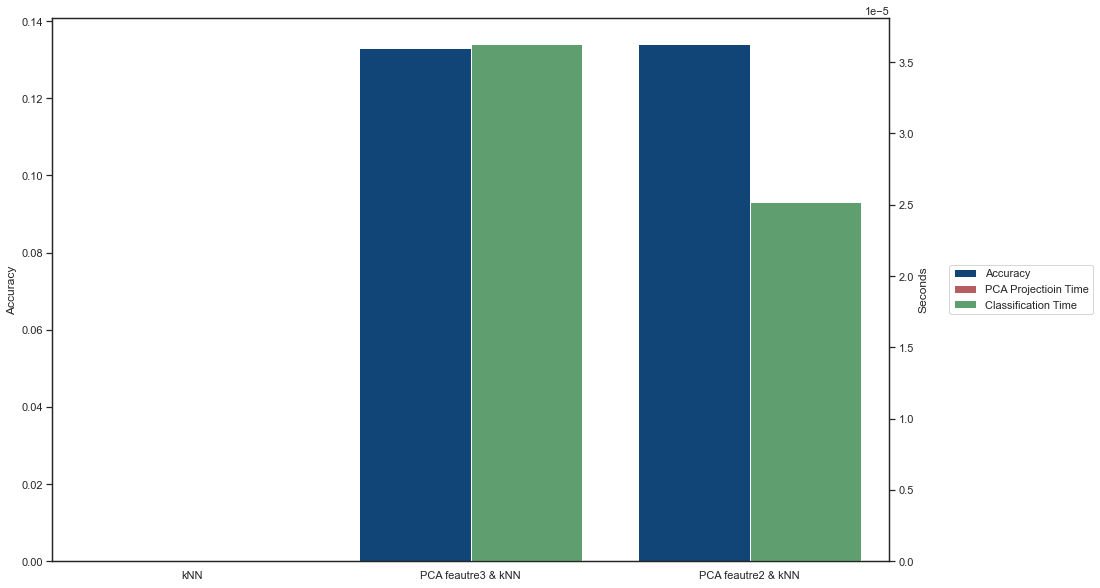

In [ ]:
df_stack = pd.DataFrame(dict(
    score = [0, comparison_acc[0], comparison_acc[1]],
    projection = [0, comparison_pca_time[0], comparison_pca_time[1]],
    classifier = [0, comparison_time[0], comparison_time[1]]
))

sns.set(style="white", rc={"lines.linewidth": 3})

fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

sns.barplot(x=["kNN", "PCA feautre3 & kNN", "PCA feautre2 & kNN"],
            y="score",
            data=df_stack,
            label="Accuracy",
            color='#004488',
            ax=ax1)

sns.barplot(x=["kNN", "PCA feautre3 & kNN", "PCA feautre2 & kNN"], 
            y="projection",
            data=df_stack,
            label="PCA Projectioin Time",
            color='r',
            ax=ax2)

sns.barplot(x=["kNN", "PCA feautre3 & kNN", "PCA feautre2 & kNN"], 
            y="classifier",
            data=df_stack,
            label="Classification Time",
            color='g',
            ax=ax2)

ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Seconds")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

lines = lines_1 + lines_2
labels = labels_1 + labels_2

width_scale = 0.5

for bar in ax1.containers[0]:
    bar.set_width(bar.get_width() * width_scale)

for bar_containers in ax2.containers:
    for bar in bar_containers:
        x = bar.get_x()
        w = bar.get_width()
        bar.set_x(x + w * (1- width_scale))
        bar.set_width(w * width_scale)

plt.legend(lines, labels, loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.show()
sns.set()